# 4. DETECÇÃO DE FRAUDES COM AUTOENCODER (RECONSTRUÇÃO)

# === IMPORTAÇÃO DE BIBLIOTECAS ===

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam


# === 1. CARGA DO DATASET ===

In [2]:
df = pd.read_csv("creditcard.csv")
print("Total de transações:", len(df))
print("Total de fraudes:", df['Class'].sum())

Total de transações: 284807
Total de fraudes: 492


# === 2. PRÉ-PROCESSAMENTO ===

In [3]:
X = df.drop("Class", axis=1)
y = df["Class"]

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisão treino/teste ANTES do SMOTE

In [5]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train = X_train_full[y_train_full == 0]  # apenas transações legítimas para treino

# === 3. CONSTRUÇÃO DO AUTOENCODER ===

In [6]:
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
encoded = Dense(4, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,362 (5.32 KB)

 Trainable params: 1,362 (5.32 KB)

 Non-trainable params: 0 (0.00 B)

# === 4. TREINAMENTO ===

In [7]:
autoencoder.fit(X_train, X_train, epochs=20, batch_size=32, shuffle=True, validation_split=0.1)

Epoch 1/20
6398/6398 ━━━━━━━━━━━━━━━━━━━━ 7s 878us/step - loss: 0.7911 - val_loss: 0.6661
Epoch 2/20
6398/6398 ━━━━━━━━━━━━━━━━━━━━ 10s 826us/step - loss: 0.6206 - val_loss: 0.5966
Epoch 3/20
6398/6398 ━━━━━━━━━━━━━━━━━━━━ 5s 846us/step - loss: 0.5947 - val_loss: 0.5963
Epoch 4/20
6398/6398 ━━━━━━━━━━━━━━━━━━━━ 5s 825us/step - loss: 0.5816 - val_loss: 0.5696
Epoch 5/20
6398/6398 ━━━━━━━━━━━━━━━━━━━━ 5s 839us/step - loss: 0.5677 - val_loss: 0.5657
Epoch 6/20
6398/6398 ━━━━━━━━━━━━━━━━━━━━ 5s 854us/step - loss: 0.5587 - val_loss: 0.5517
Epoch 7/20
6398/6398 ━━━━━━━━━━━━━━━━━━━━ 5s 828us/step - loss: 0.5527 - val_loss: 0.5424
Epoch 8/20
6398/6398 ━━━━━━━━━━━━━━━━━━━━ 5s 800us/step - loss: 0.5461 - val_loss: 0.5399
Epoch 9/20
6398/6398 ━━━━━━━━━━━━━━━━━━━━ 5s 809us/step - loss: 0.5567 - val_loss: 0.5386
Epoch 10/20
6398/6398 ━━━━━━━━━━━━━━━━━━━━ 6s 903us/step - loss: 0.5333 - val_loss: 0.5394
Epoch 11/20
6398/6398 ━━━━━━━━━━━━━━━━━━━━ 5s 831us/step - loss: 0.5385 - val_loss: 0.5319
Epoch 1

# === 5. AVALIAÇÃO ===

In [8]:
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
limiar = np.percentile(mse, 95)  # top 5% como anomalia
y_pred = (mse > limiar).astype(int)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step


In [9]:
print("\n=== MATRIZ DE CONFUSÃO ===")
print(confusion_matrix(y_test, y_pred))

print("\n=== RELATÓRIO DE CLASSIFICAÇÃO ===")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, mse)
print(f"\n=== ROC-AUC (baseado no erro de reconstrução): {auc:.4f} ===")


=== MATRIZ DE CONFUSÃO ===
[[54099  2765]
 [   14    84]]

=== RELATÓRIO DE CLASSIFICAÇÃO ===
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.86      0.06        98

    accuracy                           0.95     56962
   macro avg       0.51      0.90      0.52     56962
weighted avg       1.00      0.95      0.97     56962


=== ROC-AUC (baseado no erro de reconstrução): 0.9494 ===


# Heatmap da matriz de confusão

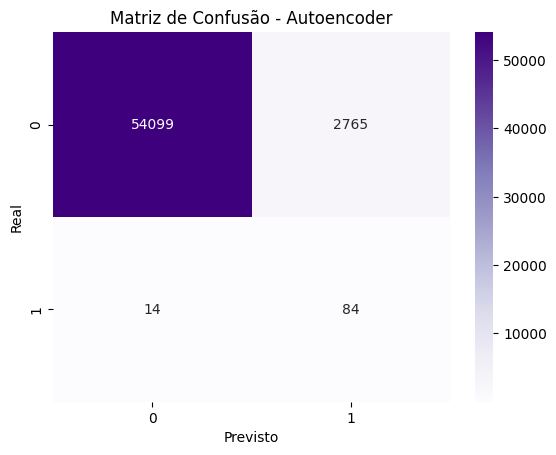

In [10]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Purples")
plt.title("Matriz de Confusão - Autoencoder")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()